# Visualizing the mouse behavior (Opto Trials)

In [1]:
import sys
sys.path.append('/Users/Sabatini Lab/GitHub/mouse_bandit/data_preprocessing_code')
sys.path.append('/Users/Sabatini Lab/GitHub/mouse_bandit')
import support_functions as sf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
import bandit_preprocessing as bp
import sklearn.linear_model
from sklearn import discriminant_analysis
from sklearn import model_selection
from sklearn import tree as Tree
import sklearn.tree
import sys
import os
%matplotlib inline 

## load in csv files (from running exportTrials.m)

In [2]:
data = pd.read_csv('/Users/Sabatini Lab/GitHub/mouse_bandit/data/mike_data/trial_data/0.1opto_trials_9010_high_processed.csv',index_col=0)

In [3]:
data.tail(10)

,Mouse ID,Session ID,Trial,Block Trial,Block Reward,Port Streak,Reward Streak,10_Port,10_Reward,10_ITI,...,1_Reward,1_ITI,1_trialDuration,0_ITI,0_trialDuration,Decision,Switch,Higher p port,Reward,Laser
545,SOM45,08212017_SOM45,556,17,4,6,-5,0,0,1.397,...,0,1.359,0.617,2.627,0.752,0,0,0,0,1
546,SOM45,08212017_SOM45,557,18,4,7,-6,0,0,1.497,...,0,2.627,0.752,1.288,0.530,1,1,1,1,0
547,SOM45,08212017_SOM45,558,19,5,1,1,0,0,1.360,...,1,1.288,0.530,1.169,0.588,0,1,0,0,0
548,SOM45,08212017_SOM45,559,20,5,1,-1,1,1,3.054,...,0,1.169,0.588,2.134,0.386,0,0,0,0,0
549,SOM45,08212017_SOM45,560,21,5,2,-2,0,1,1.421,...,0,2.134,0.386,1.268,0.566,0,0,0,1,0
550,SOM45,08212017_SOM45,561,22,6,3,1,0,0,1.977,...,1,1.268,0.566,1.452,0.442,0,0,0,0,0
551,SOM45,08212017_SOM45,562,23,6,4,-1,0,0,1.310,...,0,1.452,0.442,1.149,0.519,0,0,0,0,0
552,SOM45,08212017_SOM45,563,24,6,5,-2,0,0,1.489,...,0,1.149,0.519,1.922,0.662,0,0,0,0,0
553,SOM45,08212017_SOM45,564,25,6,6,-3,0,0,1.306,...,0,1.922,0.662,1.388,0.605,0,0,0,1,0
554,SOM45,08212017_SOM45,565,26,7,7,1,0,0,1.359,...,1,1.388,0.605,2.436,0.577,0,0,0,0,0


In [4]:
data.shape


(16594, 54)

In [5]:
np.unique(data['Reward Streak'])

array([-25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13,
       -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   1,
         2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46], dtype=int64)

In [6]:
data[data['Reward Streak'] == -1]['Switch'].mean()

0.22679425837320574

In [7]:
data['Laser'].mean()

0.099855369410630349

## separate back into individual mice for mouse to mouse comparison

In [8]:
np.unique(data['Mouse ID'])

array(['PV30', 'SOM41', 'SOM42', 'SOM44', 'SOM45'], dtype=object)

In [9]:
data_SOM42 = data[data['Mouse ID'] == 'SOM42']
data_SOM41 = data[data['Mouse ID'] == 'SOM41']
data_SOM44 = data[data['Mouse ID'] == 'SOM44']
data_SOM45 = data[data['Mouse ID'] == 'SOM45']
#data_PV30 = data[data['Mouse ID'] == 'PV30']

datas = []

for s in np.unique(data['Session ID'].values):
    #datas.append(data_PV30[data_PV30['Session ID'] == s])
    datas.append(data_SOM42[data_SOM42['Session ID'] == s])
    datas.append(data_SOM44[data_SOM44['Session ID'] == s])
    datas.append(data_SOM45[data_SOM45['Session ID'] == s])
    datas.append(data_SOM41[data_SOM41['Session ID'] == s])

In [10]:
data_SOM42.shape, data_SOM44.shape, data_SOM45.shape, data_SOM41.shape

((2062, 54), (3858, 54), (5975, 54), (4104, 54))

In [11]:
data_SOM42['Switch'].mean(), data_SOM41['Switch'].mean(), data_SOM44['Switch'].mean(), data_SOM45['Switch'].mean()

(0.059650824442289037,
 0.069931773879142303,
 0.079834110938309999,
 0.13589958158995816)

# p(switch) | switched in ith previous trial

In [12]:
p_switch = np.zeros(20)
for i in np.arange(0,20):
    p_switch[i] = data.iloc[np.where(data['Switch'].values == 1)[0]-i]['Switch'].mean(axis=0)

In [13]:
p_switchy = np.zeros((len(datas),20))

for s,d in enumerate(datas):
    for i in np.arange(0,20):
        p_switchy[s,i] = d.iloc[np.where(d['Switch'].values == 1)[0]-i]['Switch'].mean(axis=0)

In [14]:
errors = p_switchy.std(axis=0) / np.sqrt(len(p_switchy))

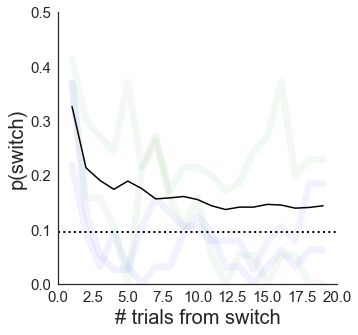

In [16]:
sns.set_style('white')
plt.figure(figsize=(5,5))
for s in range(20):
    if (s%2 == 0):
        plt.plot(np.arange(1,20),p_switchy[s,1:],alpha=0.05,linewidth=7,color='blue')
    else:
        plt.plot(np.arange(1,20),p_switchy[s,1:],alpha=0.05,linewidth=7,color='green')
        
plt.hlines(y=data['Switch'].mean(axis=0),xmin=0,xmax=20,color='black',alpha=1,linewidth=2,linestyles='dotted',label='average')
plt.plot(np.arange(1,20),p_switch[1:],color='black',linewidth=1.5)
plt.fill_between(np.arange(1,20),p_switch[1:]+errors[1:],p_switch[1:]-errors[1:],color='grey')
plt.xlim(0,20)
plt.ylim(0,0.5)
plt.xlabel('# trials from switch',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
sns.despine()

## Analysis of block switches

In [17]:
data.shape

(16594, 54)

In [18]:
t_block_unique = np.unique(data['Block Trial'].values)
p_switch_block = np.zeros((t_block_unique.shape[0],2))
high_p_port = np.zeros_like(p_switch_block)
trial_block_count = np.zeros_like(t_block_unique)

for t in t_block_unique:
    p_switch_block[int(t),0] = data[data['Block Trial'] == t]['Switch'].mean(axis=0)
    trial_block_count[int(t)] = data[data['Block Trial'] == t].shape[0]
    p_switch_block[int(t),1] = data[data['Block Trial'] == t]['Switch'].std(axis=0) / np.sqrt(trial_block_count[int(t)])
    
    high_p_port[int(t),0] = data[data['Block Trial']==t]['Higher p port'].mean(axis=0)
    high_p_port[int(t),1] = data[data['Block Trial']==t]['Higher p port'].std(axis=0) / np.sqrt(trial_block_count[int(t)])
    

total # of blocks in dataset: ~245


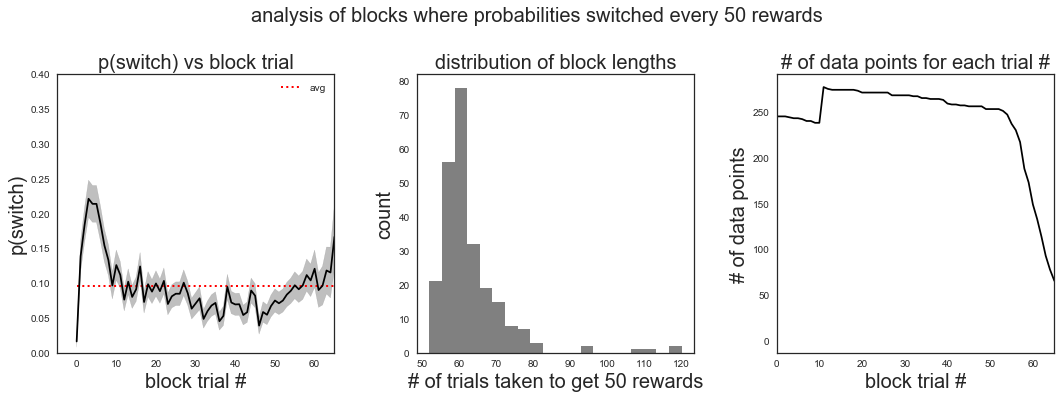

In [19]:
x_end=65
plt.figure(figsize=(15,5))
plt.suptitle('analysis of blocks where probabilities switched every 50 rewards',x=0.5,y=1.1,fontsize=20)

plt.subplot(131)
plt.plot(t_block_unique,p_switch_block[:,0],color='black')
plt.fill_between(t_block_unique,p_switch_block[:,0]+p_switch_block[:,1],p_switch_block[:,0]-p_switch_block[:,1],color='grey',alpha=0.5)
plt.hlines(data['Switch'].mean(axis=0),xmin=0,xmax=x_end,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.legend(loc='upper right')
plt.xlim(-5,x_end)
plt.ylim(0,0.4)
plt.xlabel('block trial #',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) vs block trial',fontsize=20)

plt.subplot(132)
plt.hist(data.iloc[np.where(data['Block Trial']==0)[0]-1]['Block Trial'],bins=20,color='grey')
plt.title('distribution of block lengths',fontsize=20)
plt.xlabel('# of trials taken to get 50 rewards',fontsize=20)
plt.ylabel('count',fontsize=20)

plt.subplot(133)
plt.plot(t_block_unique,trial_block_count,color='black')
plt.title('# of data points for each trial #',fontsize=20)
plt.ylabel('# of data points',fontsize=20)
plt.xlabel('block trial #',fontsize=20)
plt.xlim(0,x_end)

plt.tight_layout()
print('total # of blocks in dataset: ~%.0f' % (np.sum(data['Block Trial']==0)))

In [20]:
data.index = np.arange(data.shape[0])

In [21]:
switch_points = data[data['Block Trial'] == 0 ].index.values

L = 15
paraswitch = np.zeros((switch_points.shape[0],L*2 + 10))
paraswitch_port = np.zeros_like(paraswitch)

for i,point in enumerate(switch_points):

    paraswitch[i,:] = data.iloc[point-L:point+L+10]['Switch']
    paraswitch_port[i,:] = data.iloc[point-L:point+L+10]['Higher p port']
# if final block ends before 40 trials will show error "could not broadcast input array from shape (26) into shape (40)"

total # of blocks in dataset: ~245


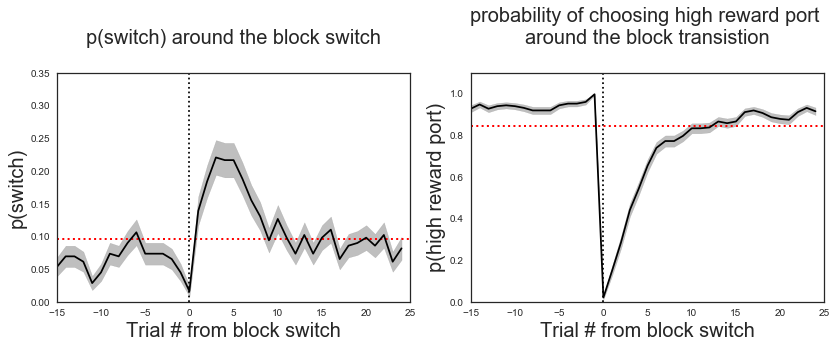

In [23]:
u = paraswitch.mean(axis=0)
s = paraswitch.std(axis=0)
SE = s/np.sqrt(paraswitch.shape[0])
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(np.arange(-1*L,L+10),u,color='black')
plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=0.5,color='black',linestyle='dotted')
plt.hlines(data['Switch'].mean(axis=0),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from block switch',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the block switch',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L+10)
plt.ylim(0,0.35)

plt.subplot(122)
u = paraswitch_port.mean(axis=0)
s = paraswitch_port.std(axis=0)
SE = s/np.sqrt(paraswitch_port.shape[0])
plt.plot(np.arange(-1*L,L+10),u,color='black')
plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=1.1,color='black',linestyle='dotted')
plt.hlines(data['Higher p port'].mean(),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from block switch',fontsize=20)
plt.ylabel('p(high reward port)',fontsize=20)
plt.title('probability of choosing high reward port \naround the block transistion',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L+10)
plt.ylim(0,1.1)

plt.tight_layout()
print('total # of blocks in dataset: ~%.0f' % (np.sum(data['Block Trial']==0)))

## look at individual mice

In [24]:
data_SOM42 = data[data['Mouse ID'] == 'SOM42']
#data_PV30 = data[data['Mouse ID'] == 'PV30']
data_SOM41 = data[data['Mouse ID'] == 'SOM41']
data_SOM44 = data[data['Mouse ID'] == 'SOM44']
data_SOM45 = data[data['Mouse ID'] == 'SOM45']


In [25]:
mice = [data_SOM44, data_SOM42, data_SOM41, data_SOM45]

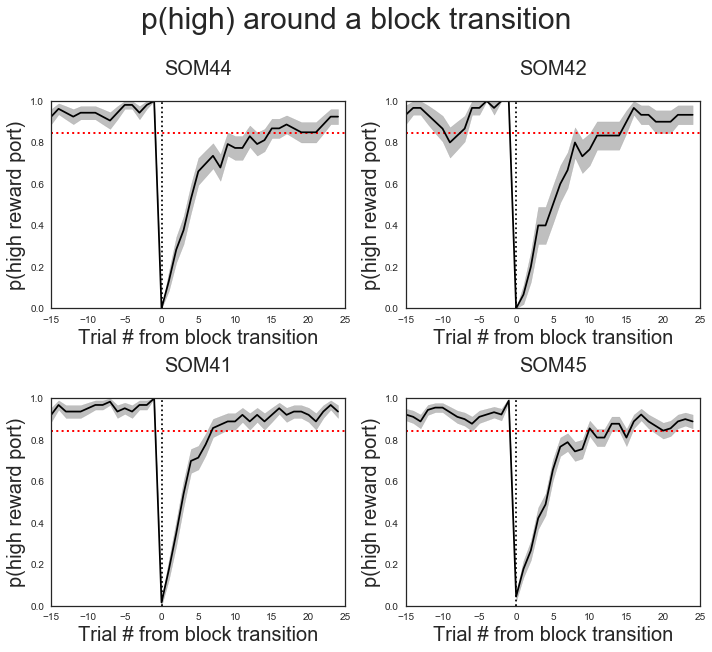

In [26]:
fig = plt.figure(figsize=(10,12))
plt.suptitle('p(high) around a block transition',x=0.5,y=1.05,fontsize=30)

for i,mouse in enumerate(mice):

    switch_points = mouse[mouse['Block Trial'] == 0 ].index.values

    L = 15
    paraswitch = np.zeros((switch_points.shape[0],L*2 + 10))
    paraswitch_port = np.zeros_like(paraswitch)

    for j,point in enumerate(switch_points):

        paraswitch[j,:] = data.iloc[point-L:point+L+10]['Switch']
        paraswitch_port[j,:] = data.iloc[point-L:point+L+10]['Higher p port'] 
        
    plt.subplot(3,2,i+1)
    u = paraswitch_port.mean(axis=0)
    s = paraswitch_port.std(axis=0)
    SE = s/np.sqrt(paraswitch.shape[0])
    plt.plot(np.arange(-1*L,L+10),u,color='black')
    plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
    plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
    plt.hlines(data['Higher p port'].mean(),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
    plt.xlabel('Trial # from block transition',fontsize=20)
    plt.ylabel('p(high reward port)',fontsize=20)
    plt.title(mouse['Mouse ID'].values[0], fontsize=20,x=0.5,y=1.1)
    plt.xlim(-1*L,L+10)
    plt.ylim(0,1)
        
plt.tight_layout()

In [27]:
 data_SOM42.shape, data_SOM44.shape, data_SOM45.shape, data_SOM41.shape

((2062, 54), (3858, 54), (5975, 54), (4104, 54))

In [28]:
data['Switch'].mean()

0.095697239966252859

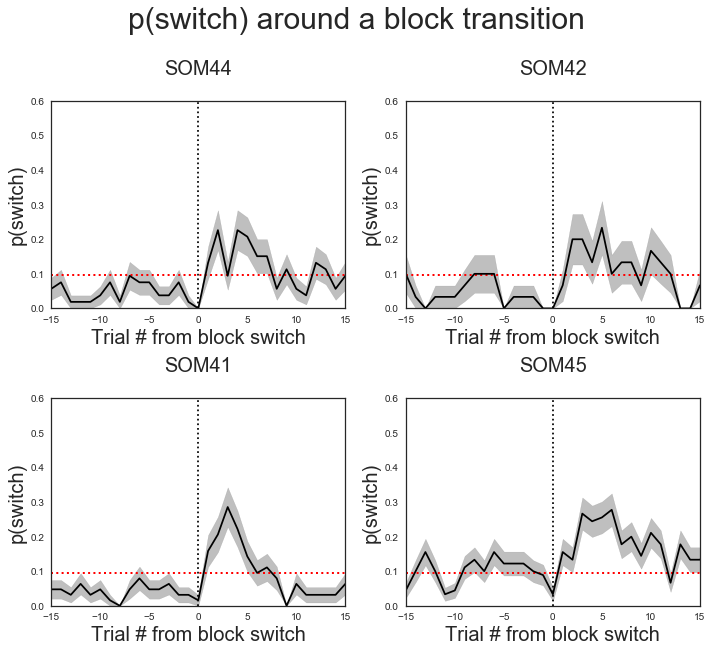

In [29]:
fig = plt.figure(figsize=(10,12))
plt.suptitle('p(switch) around a block transition',x=0.5,y=1.05,fontsize=30)

for i,mouse in enumerate(mice):

    switch_points = mouse[mouse['Block Trial'] == 0 ].index.values

    L = 15
    paraswitch = np.zeros((switch_points.shape[0],L*2 + 10))
    paraswitch_port = np.zeros_like(paraswitch)

    for j,point in enumerate(switch_points):

        paraswitch[j,:] = data.iloc[point-L:point+L+10]['Switch']
        paraswitch_port[j,:] = data.iloc[point-L:point+L+10]['Switch'] 
        
    plt.subplot(3,2,i+1)
    u = paraswitch_port.mean(axis=0)
    s = paraswitch_port.std(axis=0)
    SE = s/np.sqrt(paraswitch.shape[0])
    plt.plot(np.arange(-1*L,L+10),u,color='black')
    plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
    plt.vlines(x=0,ymin=0,ymax=0.6,color='black',linestyle='dotted')
    plt.hlines(data['Switch'].mean(axis=0),xmin=-1*L,xmax=L+1,color='red',linestyle='dotted',label='avg',linewidth=2)
    plt.xlabel('Trial # from block switch',fontsize=20)
    plt.ylabel('p(switch)',fontsize=20)
    plt.title(mouse['Mouse ID'].values[0],fontsize=20,x=0.5,y=1.1)
    plt.xlim(-1*L,L)
    plt.ylim(0,0.6)
        
plt.tight_layout()

In [30]:
data_SOM42.shape, data_SOM44.shape, data_SOM45.shape, data_SOM41.shape

((2062, 54), (3858, 54), (5975, 54), (4104, 54))

## Look at Opto Stim trials

 code was modified to look at trials when laser was given.  paralaser is an array that looks at switches 15 trials before and 25 trials after a laser stim trial.  doesn not take into account any other trial params such as trial block number or if the trial was rewarded or not.
 
 

In [31]:
switch_laser = data[data['Laser'] == 1 ].index.values

L = 15
paralaser = np.zeros((switch_laser.shape[0],L*2))
paralaser_port = np.zeros_like(paralaser)

for i,point in enumerate(switch_laser):

    paralaser[i,:] = data.iloc[point-L:point+L]['Switch']
    paralaser_port[i,:] = data.iloc[point-L:point+L]['Higher p port']

ValueError: could not broadcast input array from shape (28) into shape (30)

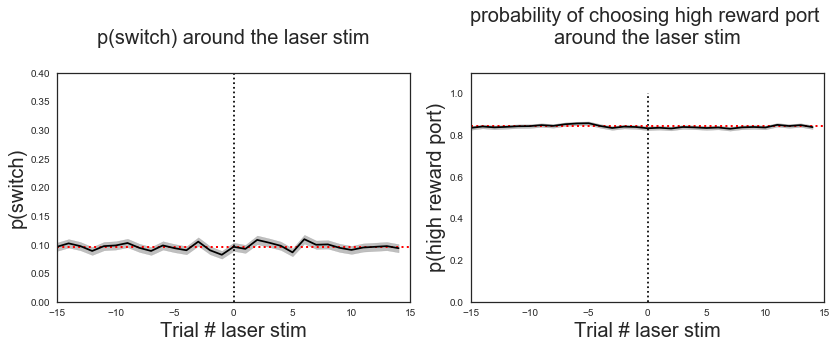

In [32]:
u = paralaser.mean(axis=0)
s = paralaser.std(axis=0)
SE = s/np.sqrt(paralaser.shape[0])
plt.figure(figsize=(12,5))


plt.subplot(121)
plt.plot(np.arange(-1*L,L),u,color='black')
plt.fill_between(np.arange(-1*L,L),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=0.5,color='black',linestyle='dotted')
plt.hlines(data['Switch'].mean(axis=0),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # laser stim',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the laser stim',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,0.4)


plt.subplot(122)
u = paralaser_port.mean(axis=0)
s = paralaser_port.std(axis=0)
SE = s/np.sqrt(paralaser.shape[0])
plt.plot(np.arange(-1*L,L),u,color='black')
plt.fill_between(np.arange(-1*L,L),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
plt.hlines(data['Higher p port'].mean(),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # laser stim',fontsize=20)
plt.ylabel('p(high reward port)',fontsize=20)
plt.title('probability of choosing high reward port \naround the laser stim',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,1.1)

plt.tight_layout()

## p(switch) around a laser stim in individual mice

In [33]:
mice = [data_SOM41, data_SOM42, data_SOM44, data_SOM45 ]

ValueError: could not broadcast input array from shape (30) into shape (40)

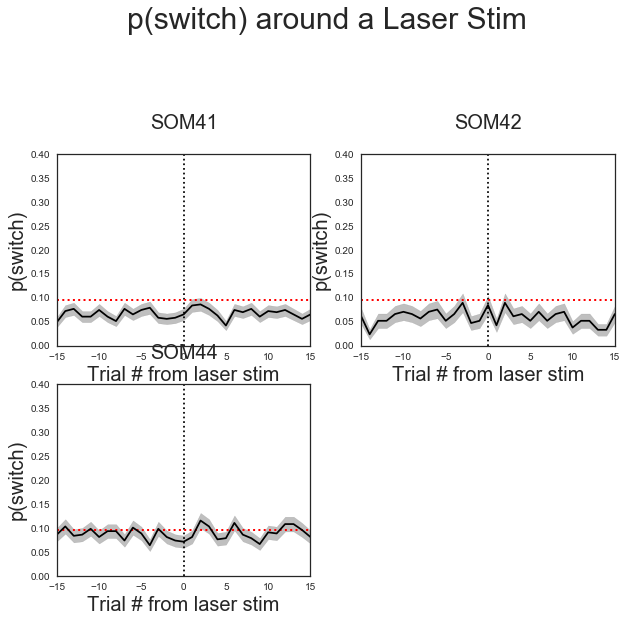

In [34]:
fig = plt.figure(figsize=(10,12))
plt.suptitle('p(switch) around a Laser Stim',x=0.5,y=1.05,fontsize=30)

for i,mouse in enumerate(mice):

    switch_laser = mouse[mouse['Laser'] == 1 ].index.values

    L = 15
    paralaser = np.zeros((switch_laser.shape[0],L*2 + 10))
    paralaser_port = np.zeros_like(paralaser)

    for j,point in enumerate(switch_laser):

        paralaser[j,:] = data.iloc[point-L:point+L+10]['Switch']
        paralaser_port[j,:] = data.iloc[point-L:point+L+10]['Switch'] 
        
    plt.subplot(3,2,i+1)
    u = paralaser_port.mean(axis=0)
    s = paralaser_port.std(axis=0)
    SE = s/np.sqrt(paralaser.shape[0])
    plt.plot(np.arange(-1*L,L+10),u,color='black')
    plt.fill_between(np.arange(-1*L,L+10),u+SE,u-SE,color='grey',alpha=0.5)
    plt.vlines(x=0,ymin=0,ymax=0.5,color='black',linestyle='dotted')
    plt.hlines(data['Switch'].mean(axis=0),xmin=-1*L,xmax=L+1,color='red',linestyle='dotted',label='avg',linewidth=2)
    plt.xlabel('Trial # from laser stim',fontsize=20)
    plt.ylabel('p(switch)',fontsize=20)
    plt.title(mouse['Mouse ID'].values[0],fontsize=20,x=0.5,y=1.1)
    plt.xlim(-1*L,L)
    plt.ylim(0,0.4)
        
plt.tight_layout()

In [35]:
 data_SOM42.shape, data_SOM44.shape, data_SOM45.shape, data_SOM41.shape

((2062, 54), (3858, 54), (5975, 54), (4104, 54))

## breakdown laser trials into those that were rewarded/unrewarded

In [36]:
switch_laser_rew = data[((data['Laser'] == 1) & (data['Reward'] == 1)) ].index.values

L = 15
paralaser_rew = np.zeros((switch_laser_rew.shape[0],L*2))

for i,point in enumerate(switch_laser_rew):

    paralaser_rew[i,:] = data.iloc[point-L:point+L]['Switch']

In [37]:
switch_laser_norew = data[((data['Laser'] == 1) & (data['Reward'] == 0)) ].index.values

paralaser_norew = np.zeros((switch_laser_norew.shape[0],L*2))

for j,point in enumerate(switch_laser_norew): 
    
    paralaser_norew[j,:] = data.iloc[point-L:point+L]['Switch']

ValueError: could not broadcast input array from shape (28) into shape (30)

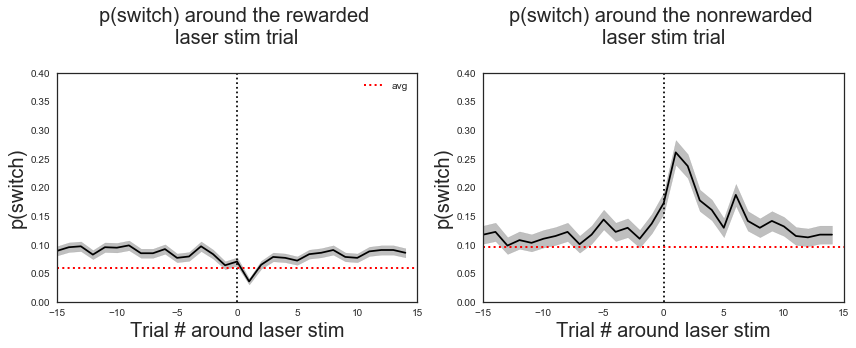

In [38]:

u = paralaser_rew.mean(axis=0)
s = paralaser_rew.std(axis=0)
SE = s/np.sqrt(paralaser_rew.shape[0])
plt.figure(figsize=(12,5))


plt.subplot(121)
plt.plot(np.arange(-1*L,L),u,color='black')
plt.fill_between(np.arange(-1*L,L),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=0.5,color='black',linestyle='dotted')
plt.hlines(data_SOM42['Switch'].mean(axis=0),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.legend(loc='upper right')
plt.xlabel('Trial # around laser stim',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the rewarded \nlaser stim trial',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,0.4)


plt.subplot(122)
u = paralaser_norew.mean(axis=0)
s = paralaser_norew.std(axis=0)
SE = s/np.sqrt(switch_laser_norew.shape[0])
plt.plot(np.arange(-1*L,L),u,color='black')
plt.fill_between(np.arange(-1*L,L),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
plt.hlines(data['Switch'].mean(),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # around laser stim',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the nonrewarded \nlaser stim trial',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,0.4)

plt.tight_layout()

## Control vs Sst comparisons (work in progress)

In [ ]:
'''Celia's additions include fail-safes for opto stim occuring at the beginning or the end of sessions.  Opto stims occuring 
closer than +- L trials to the beginning or end of the session are deleted'''

In [ ]:
#control = pd.read_csv('/Users/Sabatini Lab/GitHub/mouse_bandit/control.csv',index_col=0)

In [ ]:
#np.set_printoptions(threshold=np.inf) #to display entire arrays rather than top and bottom

In [39]:
data_SOM42 = data[data['Mouse ID'] == 'SOM42']
data_SOM41 = data[data['Mouse ID'] == 'SOM41']
data_SOM44 = data[data['Mouse ID'] == 'SOM44']
data_SOM45 = data[data['Mouse ID'] == 'SOM45']
#data_PV30 = data[data['Mouse ID'] == 'PV30']

add = [data_SOM44, data_SOM45]

control = pd.concat(add)


In [40]:
switch_laser_rew1 = control[((control['Laser'] == 1) & (control['Reward'] == 1)) ].index.values
L = 15
paralaser_rew1 = np.zeros((switch_laser_rew1.shape[0],(L*2)+1))
for k,point in enumerate(switch_laser_rew1):
        try:
            control.loc[point+L]['Trial'] and control.loc[point-L]['Trial']
            if control.loc[point]['Trial'] + L != control.loc[point+L]['Trial']:
                paralaser_rew1[k,:] = 'NaN'
            elif control.loc[point]['Trial'] - L != control.loc[point-L]['Trial']:
                paralaser_rew1[k,:] = 'NaN'
            else:
                paralaser_rew1[k,:] = control.loc[point-L:point+L]['Switch']
        except KeyError:
            paralaser_rew1[k,:] = 'NaN'
    #elif control.loc[point]['Trial'] <15: 
    #    paralaser_rew1[k,:] = 'NaN'

num_errors_rew1 = np.sum(np.isnan(paralaser_rew1))/(2*L+1)
print(num_errors_rew1)

54.0


In [41]:
switch_laser_rew1.shape

(687,)

In [42]:
switch_laser_norew1 = control[((control['Laser'] == 1) & (control['Reward'] == 0)) ].index.values
paralaser_norew1 = np.zeros((switch_laser_norew1.shape[0],L*2+1))
for j,point in enumerate(switch_laser_norew1):
        try:
            control.loc[point+L]['Trial'] and control.loc[point-L]['Trial']
            if control.loc[point]['Trial'] + L != control.loc[point+L]['Trial']:
                paralaser_norew1[j,:] = 'NaN'
            elif control.loc[point]['Trial'] - L != control.loc[point-L]['Trial']:
                paralaser_norew1[j,:] = 'NaN'
            else:
                paralaser_norew1[j,:] = control.loc[point-L:point+L]['Switch']
        except KeyError:
            paralaser_rew1[j,:] = 'NaN'
    #elif control.loc[point]['Trial'] <15: 
    #    paralaser_rew1[k,:] = 'NaN'
    
num_errors_norew1 = np.sum(np.isnan(paralaser_norew1))/(2*L+1)
print(num_errors_norew1)

16.0


In [43]:
add1 = [data_SOM41, data_SOM42]
sst = pd.concat(add1)

In [44]:
switch_laser_rew2 = sst[((sst['Laser'] == 1) & (sst['Reward'] == 1)) ].index.values  # set laser to 0
L = 15
paralaser_rew2 = np.zeros((switch_laser_rew2.shape[0],(L*2)+1))
for k,point in enumerate(switch_laser_rew2):
        try:
            sst.loc[point+L]['Trial'] and sst.loc[point-L]['Trial']
            if sst.loc[point]['Trial'] + L != sst.loc[point+L]['Trial']:
                paralaser_rew2[k,:] = 'NaN'
            elif sst.loc[point]['Trial'] - L != sst.loc[point-L]['Trial']:
                paralaser_rew2[k,:] = 'NaN'
            else:
                paralaser_rew2[k,:] = sst.loc[point-L:point+L]['Switch']
        except KeyError:
            paralaser_rew2[k,:] = 'NaN'
    #elif control.loc[point]['Trial'] <15: 
    #    paralaser_rew1[k,:] = 'NaN'

num_errors_rew2 = np.sum(np.isnan(paralaser_rew2))/(2*L+1)
print(num_errors_rew2)

30.0


In [45]:
switch_laser_norew2 = sst[((sst['Laser'] == 1) & (sst['Reward'] == 0)) ].index.values # set laser to 0
paralaser_norew2 = np.zeros((switch_laser_norew2.shape[0],L*2+1))
for j,point in enumerate(switch_laser_norew2):
        try:
            sst.loc[point+L]['Trial'] and sst.loc[point-L]['Trial']
            if sst.loc[point]['Trial'] + L != sst.loc[point+L]['Trial']:
                paralaser_norew2[j,:] = 'NaN'
            elif sst.loc[point]['Trial'] - L != sst.loc[point-L]['Trial']:
                paralaser_norew2[j,:] = 'NaN'
            else:
                paralaser_norew2[j,:] = sst.loc[point-L:point+L]['Switch']
        except KeyError:
            paralaser_rew2[j,:] = 'NaN'
    #elif control.loc[point]['Trial'] <15: 
    #    paralaser_rew1[k,:] = 'NaN'
    
num_errors_norew2 = np.sum(np.isnan(paralaser_norew2))/(2*L+1)
print(num_errors_norew2)

5.0


In [83]:
#df = pd.DataFrame(paranolaser_rew1)

In [84]:
#df.to_csv(path_or_buf='/Users/Sabatini Lab/GitHub/mouse_bandit/paranolaser_rew1.csv')

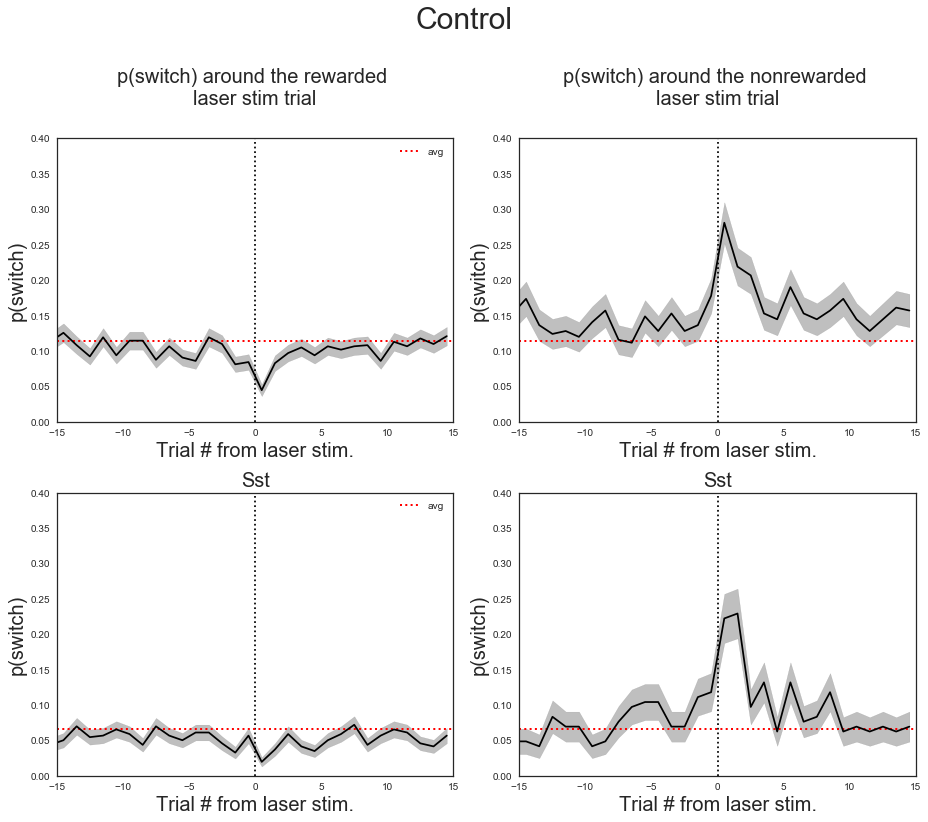

In [46]:
u = np.nanmean(paralaser_rew1, axis=0)
s = np.nanstd(paralaser_rew1, axis=0)
SE = s/np.sqrt(paralaser_rew1.shape[0]-num_errors_rew1)

plt.figure(figsize=(13,15))
plt.suptitle('Control',x=0.5,y=1.05,fontsize=30)

plt.subplot(321)
plt.plot(np.arange(-1*L-.5,L+.5),u,color='black')
plt.fill_between(np.arange(-1*L-.5,L+.5),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=0.5,color='black',linestyle='dotted')
plt.hlines(control['Switch'].mean(axis=0),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.legend(loc='upper right')
plt.xlabel('Trial # from laser stim.',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the rewarded \nlaser stim trial',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,0.4)


plt.subplot(322)
u = np.nanmean(paralaser_norew1, axis=0)
s = np.nanstd(paralaser_norew1, axis=0)
SE = s/np.sqrt(switch_laser_norew1.shape[0]-num_errors_norew1)

plt.plot(np.arange(-1*L-.5,L+.5),u,color='black')
plt.fill_between(np.arange(-1*L-.5,L+.5),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
plt.hlines(control['Switch'].mean(),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from laser stim.',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the nonrewarded \nlaser stim trial',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,0.4)


plt.subplot(323)
u = np.nanmean(paralaser_rew2, axis=0)
s = np.nanstd(paralaser_rew2, axis=0)
SE = s/np.sqrt(paralaser_rew2.shape[0]-num_errors_rew2)

plt.plot(np.arange(-1*L-.5,L+.5),u,color='black')
plt.fill_between(np.arange(-1*L-.5,L+.5),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=0.5,color='black',linestyle='dotted')
plt.hlines(sst['Switch'].mean(axis=0),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.legend(loc='upper right')
plt.xlabel('Trial # from laser stim.',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('Sst',fontsize=20,x=0.5,y=1)
plt.xlim(-1*L,L)
plt.ylim(0,0.4)


plt.subplot(324)
u = np.nanmean(paralaser_norew2, axis=0)
s = np.nanstd(paralaser_norew2, axis=0)
SE = s/np.sqrt(switch_laser_norew2.shape[0]-num_errors_norew2)

plt.plot(np.arange(-1*L-.5,L+.5),u,color='black')
plt.fill_between(np.arange(-1*L-.5,L+.5),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
plt.hlines(sst['Switch'].mean(),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from laser stim.',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('Sst',fontsize=20,x=0.5,y=1)
plt.xlim(-1*L,L)
plt.ylim(0,0.4)

plt.tight_layout()

## Sst group within group comparison

In [47]:
add1 = [data_SOM41, data_SOM42]
sst = pd.concat(add1)

## rewarded trials

In [48]:
switch_laser_rew2 = sst[((sst['Laser'] == 0) & (sst['Reward'] == 1)) ].index.values  # set laser to 0
L = 15
paralaser_rew2 = np.zeros((switch_laser_rew2.shape[0],(L*2)+1))
for k,point in enumerate(switch_laser_rew2):
        try:
            sst.loc[point+L]['Trial'] and sst.loc[point-L]['Trial']
            if sst.loc[point]['Trial'] + L != sst.loc[point+L]['Trial']:
                paralaser_rew2[k,:] = 'NaN'
            elif sst.loc[point]['Trial'] - L != sst.loc[point-L]['Trial']:
                paralaser_rew2[k,:] = 'NaN'
            else:
                paralaser_rew2[k,:] = sst.loc[point-L:point+L]['Switch']
        except KeyError:
            paralaser_rew2[k,:] = 'NaN'
    #elif control.loc[point]['Trial'] <15: 
    #    paralaser_rew1[k,:] = 'NaN'

num_errors_rew2 = np.sum(np.isnan(paralaser_rew2))/(2*L+1)
print(num_errors_rew2, switch_laser_rew2.shape)

256.0 (4338,)


In [49]:
switch_laser_norew2 = sst[((sst['Laser'] == 1) & (sst['Reward'] == 1)) ].index.values # set laser to 0
paralaser_norew2 = np.zeros((switch_laser_norew2.shape[0],L*2+1))
for j,point in enumerate(switch_laser_norew2):
        try:
            sst.loc[point+L]['Trial'] and sst.loc[point-L]['Trial']
            if sst.loc[point]['Trial'] + L != sst.loc[point+L]['Trial']:
                paralaser_norew2[j,:] = 'NaN'
            elif sst.loc[point]['Trial'] - L != sst.loc[point-L]['Trial']:
                paralaser_norew2[j,:] = 'NaN'
            else:
                paralaser_norew2[j,:] = sst.loc[point-L:point+L]['Switch']
        except KeyError:
            paralaser_rew2[j,:] = 'NaN'
    #elif control.loc[point]['Trial'] <15: 
    #    paralaser_rew1[k,:] = 'NaN'
    
num_errors_norew2 = np.sum(np.isnan(paralaser_norew2))/(2*L+1)
print(num_errors_norew2, switch_laser_norew2.shape)

3.0 (495,)


(4338,) (495,)


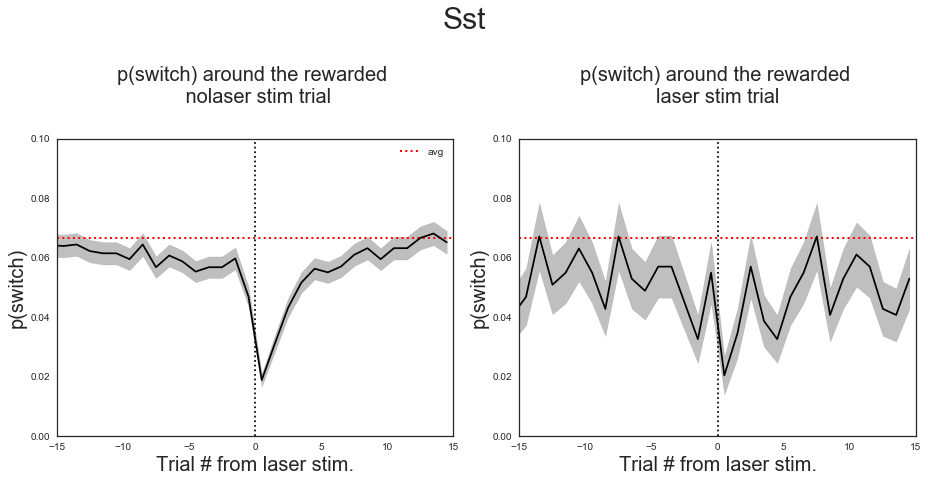

In [58]:
u = np.nanmean(paralaser_rew2, axis=0)
s = np.nanstd(paralaser_rew2, axis=0)
SE = s/np.sqrt(paralaser_rew2.shape[0]-num_errors_rew2)

plt.figure(figsize=(13,15))
plt.suptitle('Sst',x=0.5,y=1.05,fontsize=30)
plt.subplot(321)
plt.plot(np.arange(-1*L-.5,L+.5),u,color='black')
plt.fill_between(np.arange(-1*L-.5,L+.5),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=0.5,color='black',linestyle='dotted')
plt.hlines(sst['Switch'].mean(axis=0),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.legend(loc='upper right')
plt.xlabel('Trial # from laser stim.',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the rewarded \n nolaser stim trial',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,0.1)


plt.subplot(322)
u = np.nanmean(paralaser_norew2, axis=0)
s = np.nanstd(paralaser_norew2, axis=0)
SE = s/np.sqrt(switch_laser_norew2.shape[0]-num_errors_norew2)

plt.plot(np.arange(-1*L-.5,L+.5),u,color='black')
plt.fill_between(np.arange(-1*L-.5,L+.5),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
plt.hlines(sst['Switch'].mean(),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from laser stim.',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the rewarded \nlaser stim trial',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,0.1)

plt.tight_layout()

print(switch_laser_rew2.shape, switch_laser_norew2.shape)

## Unrewarded Trials

In [59]:
switch_laser_rew2 = sst[((sst['Laser'] == 0) & (sst['Reward'] == 0)) ].index.values  # set laser to 0
L = 15
paralaser_rew2 = np.zeros((switch_laser_rew2.shape[0],(L*2)+1))
for k,point in enumerate(switch_laser_rew2):
        try:
            sst.loc[point+L]['Trial'] and sst.loc[point-L]['Trial']
            if sst.loc[point]['Trial'] + L != sst.loc[point+L]['Trial']:
                paralaser_rew2[k,:] = 'NaN'
            elif sst.loc[point]['Trial'] - L != sst.loc[point-L]['Trial']:
                paralaser_rew2[k,:] = 'NaN'
            else:
                paralaser_rew2[k,:] = sst.loc[point-L:point+L]['Switch']
        except KeyError:
            paralaser_rew2[k,:] = 'NaN'
    #elif control.loc[point]['Trial'] <15: 
    #    paralaser_rew1[k,:] = 'NaN'

num_errors_rew2 = np.sum(np.isnan(paralaser_rew2))/(2*L+1)
print(num_errors_rew2, switch_laser_rew2.shape)

92.0 (1184,)


In [60]:
switch_laser_norew2 = sst[((sst['Laser'] == 1) & (sst['Reward'] == 0)) ].index.values # set laser to 0
paralaser_norew2 = np.zeros((switch_laser_norew2.shape[0],L*2+1))
for j,point in enumerate(switch_laser_norew2):
        try:
            sst.loc[point+L]['Trial'] and sst.loc[point-L]['Trial']
            if sst.loc[point]['Trial'] + L != sst.loc[point+L]['Trial']:
                paralaser_norew2[j,:] = 'NaN'
            elif sst.loc[point]['Trial'] - L != sst.loc[point-L]['Trial']:
                paralaser_norew2[j,:] = 'NaN'
            else:
                paralaser_norew2[j,:] = sst.loc[point-L:point+L]['Switch']
        except KeyError:
            paralaser_rew2[j,:] = 'NaN'
    #elif control.loc[point]['Trial'] <15: 
    #    paralaser_rew1[k,:] = 'NaN'
    
num_errors_norew2 = np.sum(np.isnan(paralaser_norew2))/(2*L+1)
print(num_errors_norew2, switch_laser_norew2.shape)

5.0 (149,)


(1184,) (149,)


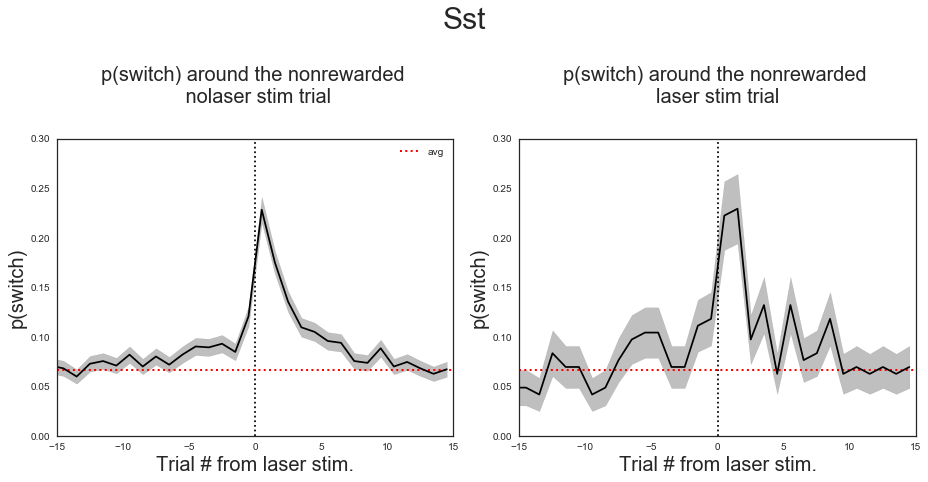

In [64]:
u = np.nanmean(paralaser_rew2, axis=0)
s = np.nanstd(paralaser_rew2, axis=0)
SE = s/np.sqrt(paralaser_rew2.shape[0]-num_errors_rew2)

plt.figure(figsize=(13,15))
plt.suptitle('Sst',x=0.5,y=1.05,fontsize=30)
plt.subplot(321)
plt.plot(np.arange(-1*L-.5,L+.5),u,color='black')
plt.fill_between(np.arange(-1*L-.5,L+.5),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=0.5,color='black',linestyle='dotted')
plt.hlines(sst['Switch'].mean(axis=0),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.legend(loc='upper right')
plt.xlabel('Trial # from laser stim.',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the nonrewarded \n nolaser stim trial',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,0.3)


plt.subplot(322)
u = np.nanmean(paralaser_norew2, axis=0)
s = np.nanstd(paralaser_norew2, axis=0)
SE = s/np.sqrt(switch_laser_norew2.shape[0]-num_errors_norew2)

plt.plot(np.arange(-1*L-.5,L+.5),u,color='black')
plt.fill_between(np.arange(-1*L-.5,L+.5),u+SE,u-SE,color='grey',alpha=0.5)
plt.vlines(x=0,ymin=0,ymax=1,color='black',linestyle='dotted')
plt.hlines(sst['Switch'].mean(),xmin=-1*L,xmax=L+10,color='red',linestyle='dotted',label='avg',linewidth=2)
plt.xlabel('Trial # from laser stim.',fontsize=20)
plt.ylabel('p(switch)',fontsize=20)
plt.title('p(switch) around the nonrewarded \nlaser stim trial',fontsize=20,x=0.5,y=1.1)
plt.xlim(-1*L,L)
plt.ylim(0,0.3)

plt.tight_layout()

print(switch_laser_rew2.shape, switch_laser_norew2.shape)

little note on the for loop below. 

took me little while because I had the order of the else-if statements wrong. 

when block_trial == 0 needs to come BEFORE whether the block trial incremented by 1 or not (which is my hokey way of detecting when a new session started where block_trial does not equal 0. 

I suppose a better way would be to detect when the block trial is 11 AND the previous block trial != 10. that would work. okay. switched it to that now. 

In [65]:
block_reward = np.zeros(data.shape[0])
for i in range(data.shape[0]):
    trial = data.iloc[i]
    
    #lets deal with weird cases first:
    #1) the first row
    if(i == 0):
        block_reward[i] = trial[['10_Reward','9_Reward','8_Reward','7_Reward','6_Reward',
                                '5_Reward','4_Reward','3_Reward','2_Reward','1_Reward','Reward']].sum()
    
    #3) the first trial of a new block
    elif (trial['Block Trial'] == 0):
        block_reward[i] = 0
    
    #2) the first trial of a new session
    elif (((trial['Block Trial'] - trial_prev['Block Trial']) != 1) and (trial['Block Trial'] == 11)):
        block_reward[i] = trial[['10_Reward','9_Reward','8_Reward','7_Reward','6_Reward',
                                '5_Reward','4_Reward','3_Reward','2_Reward','1_Reward','Reward']].sum()
    else:
        block_reward[i] = block_reward[i-1] + trial['Reward']
    
    trial_prev = trial

In [66]:
reward_switches = np.zeros(np.unique(block_reward).shape[0])
reward_switches_afterR = np.zeros(np.unique(block_reward).shape[0])
reward_switches_afterNoR = np.zeros(np.unique(block_reward).shape[0])
for i,r_block in enumerate(np.unique(block_reward)):
    reward_switches[i] = data[block_reward == r_block]['Switch'].mean()
    reward_switches_afterR[i] = data[((block_reward == r_block) & (data['1_Reward']==1))]['Switch'].mean()
    reward_switches_afterNoR[i] = data[((block_reward == r_block) & (data['1_Reward']==0))]['Switch'].mean()

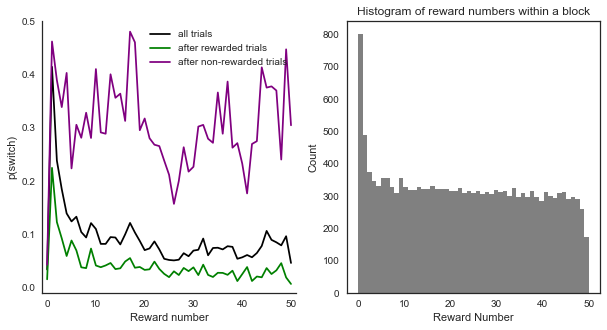

In [67]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(np.unique(block_reward),reward_switches,color='black',label='all trials')
plt.plot(np.unique(block_reward),reward_switches_afterR,color='green',label='after rewarded trials')
plt.plot(np.unique(block_reward),reward_switches_afterNoR,color='purple',label='after non-rewarded trials')
plt.xlabel('Reward number')
plt.ylabel('p(switch)')
plt.legend(loc='upper right')
plt.xlim(-1,51)
plt.ylim(-0.01,0.5)
sns.despine()

plt.subplot(122)
plt.hist(block_reward,bins=51,color='grey')
plt.title('Histogram of reward numbers within a block')
plt.xlabel('Reward Number')
plt.ylabel('Count')